In [1]:
# QUESTION 06
# Loading Models - single encoder model 
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20, pretrained=None):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True) # change for LSTM or RNN
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        self.pretrained = pretrained
        if self.pretrained:
            print(f'loading pretrained model: {pretrained}')
            weight = torch.load(self.pretrained)
            weight = weight.to(device)
            self.prembed = nn.Embedding.from_pretrained(weight, freeze=True)

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        if self.pretrained:
            embeddings = self.prembed(captions).float()
        else:
            embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, pretrained=None, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            if pretrained:
                inputs = self.prembed(predicted).float()
            else:
                inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [2]:
# Inference : single encoder 

import torch
import pickle
from torchvision import transforms
from ipynb.fs.full.vocabulary_builder import Vocabulary
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224), Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image


def main(
    image = 'selected_dataset-60000/test/radiology/images/PMC5525509_JOVR-12-351-g002.jpg',
    encoder_path = 'models/encoder-best.ckpt',
    decoder_path = 'models/decoder-best.ckpt',
    vocab_path = 'vocab_60000.pkl',
    embed_size = 512,
    hidden_size = 256,
    num_layers = 1
):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    if torch.cuda.is_available():
        map_location = torch.device('cuda')
    else:
        map_location = torch.device('cpu')

    # Build models
    encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers, max_seq_length=50)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(encoder_path, map_location=map_location))
    decoder.load_state_dict(torch.load(decoder_path, map_location=map_location))

    # Prepare an image
    image = load_image(image, transform)
    image_tensor = image.to(device)

    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()  # (1, max_seq_length) -> (max_seq_length)

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)

    return sentence

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[500/59966] Tokenized the captions.
[1000/59966] Tokenized the captions.
[1500/59966] Tokenized the captions.
[2000/59966] Tokenized the captions.
[2500/59966] Tokenized the captions.
[3000/59966] Tokenized the captions.
[3500/59966] Tokenized the captions.
[4000/59966] Tokenized the captions.
[4500/59966] Tokenized the captions.
[5000/59966] Tokenized the captions.
[5500/59966] Tokenized the captions.
[6000/59966] Tokenized the captions.
[6500/59966] Tokenized the captions.
[7000/59966] Tokenized the captions.
[7500/59966] Tokenized the captions.
[8000/59966] Tokenized the captions.
[8500/59966] Tokenized the captions.
[9000/59966] Tokenized the captions.
[9500/59966] Tokenized the captions.
[10000/59966] Tokenized the captions.
[10500/59966] Tokenized the captions.
[11000/59966] Tokenized the captions.
[11500/59966] Tokenized the captions.
[12000/59966] Tokenized the captions.
[12500/59966] Tokenized the captions.
[13000/59966] Tokenized the captions.
[13500/59966] Tokenized the capt

In [3]:
import torch
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec, FastText, KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from itertools import combinations
from nltk.tokenize import word_tokenize
import numpy as np
from scipy.spatial import distance
import json
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='nltk')

# Load pre-trained Word2Vec and FastText models
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
fasttext_model = KeyedVectors.load_word2vec_format('crawl-300d-2M.vec')


def get_embedding(sentence, embed_type):
    if embed_type == "biobert":
        # Load pre-trained model and tokenizer for BioBERT
        model_name = 'dmis-lab/biobert-base-cased-v1.1'
        biobert = BertModel.from_pretrained(model_name)
        tokenizer = BertTokenizer.from_pretrained(model_name)
        with torch.no_grad():
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)
            outputs = biobert(**inputs)
            return outputs.last_hidden_state[:, 0, :].numpy()
    else:
        words = word_tokenize(sentence)
        if embed_type == "word2vec":
            vectors = [word2vec_model[word] for word in words if word in word2vec_model.key_to_index]
        elif embed_type == "fasttext":
            vectors = [fasttext_model[word] for word in words if word in fasttext_model.key_to_index]
        else:
            raise ValueError(f"unknown {embed_type}")
        return np.mean(vectors, axis=0).reshape(1, -1)


def calculate_similarities(original, prediction, embedding_type):
    orig_embedding = get_embedding(original, embedding_type)
    pred_embedding = get_embedding(prediction, embedding_type)

    # Compute similarities
    cosine_sim = cosine_similarity(orig_embedding, pred_embedding)[0][0]
    euclidean_dist = distance.euclidean(orig_embedding.flatten(), pred_embedding.flatten())
    manhattan_dist = distance.cityblock(orig_embedding.flatten(), pred_embedding.flatten())
    bleu_score = sentence_bleu([word_tokenize(original)], word_tokenize(prediction), weights=(0, 1, 0, 0))  # bi-gram
    jaccard_sim = jaccard_similarity(word_tokenize(original), word_tokenize(prediction))

    return {
        "Cosine Similarity": cosine_sim,
        "Euclidean Distance": euclidean_dist,
        "Manhattan Distance": manhattan_dist,
        "BLEU Score": bleu_score,
        "Jaccard Similarity": jaccard_sim
    }


def calculate_countvector_similarity(original, prediction):
    # Compute similarities based on count vectors
    vectorizer = CountVectorizer().fit([original, prediction])

    # Convert sentences to count vectors
    orig_vector = vectorizer.transform([original]).toarray()[0]  # Convert sparse matrix to numpy array
    pred_vector = vectorizer.transform([prediction]).toarray()[0]  # Convert sparse matrix to numpy array

    # Compute similarities based on count vectors
    cosine_sim = cosine_similarity([orig_vector], [pred_vector])[0][0]
    euclidean_dist = distance.euclidean(orig_vector, pred_vector)
    manhattan_dist = distance.cityblock(orig_vector, pred_vector)
    bleu_score = sentence_bleu([word_tokenize(original)], word_tokenize(prediction), weights=(0, 1, 0, 0))  # bi-gram
    jaccard_sim = jaccard_similarity(word_tokenize(original), word_tokenize(prediction))

    return {
        "Cosine Similarity": cosine_sim,
        "Euclidean Distance": euclidean_dist,
        "Manhattan Distance": manhattan_dist,
        "BLEU Score": bleu_score,
        "Jaccard Similarity": jaccard_sim
    }


def sent2sent_similarity(captionA, captionB):
    """
    Question6: get the similarity between GT and the generated caption
    :param captionA: input caption/ Generated caption (Y)
    :param captionB: GT (X)
    :return: json object with different embeddings types and their similarity scores
    EX: {
            "embed_type": {
                "Cosine Similarity": float,
                "Euclidean Distance": float,
                "Manhattan Distance": float,
                "BLEU Score": float,
                "Jaccard Similarity": float
            }
        }
    """
    results = {}
    for method in ["biobert", "word2vec", "fasttext"]:
        results[method] = calculate_similarities(captionA, captionB, method)
    results['countvectorizer'] = calculate_countvector_similarity(captionA, captionB)
    return results

def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fluorescein angiography of the left eye showing a large filling defect in the left eye


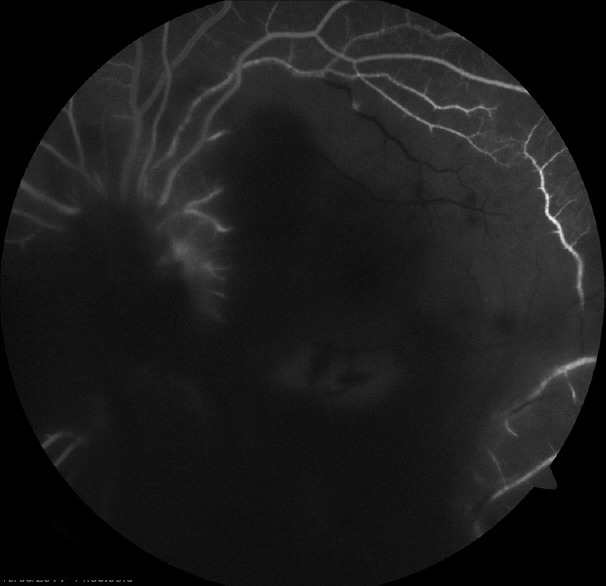

chest x-ray showing a large mass in the right lung .


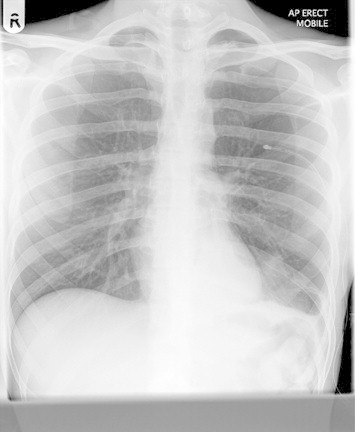

chest x-ray showing a large mass in the right lung .


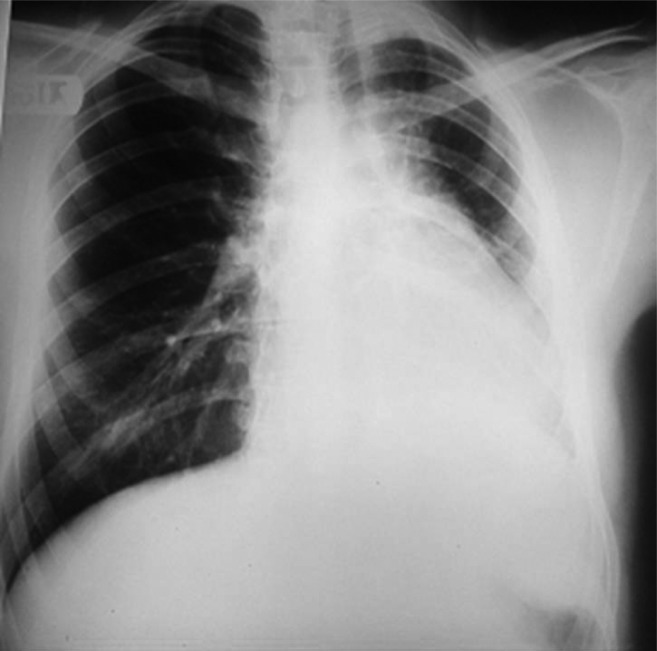

mri of the brain with contrast showing a large mass in the left frontal lobe .


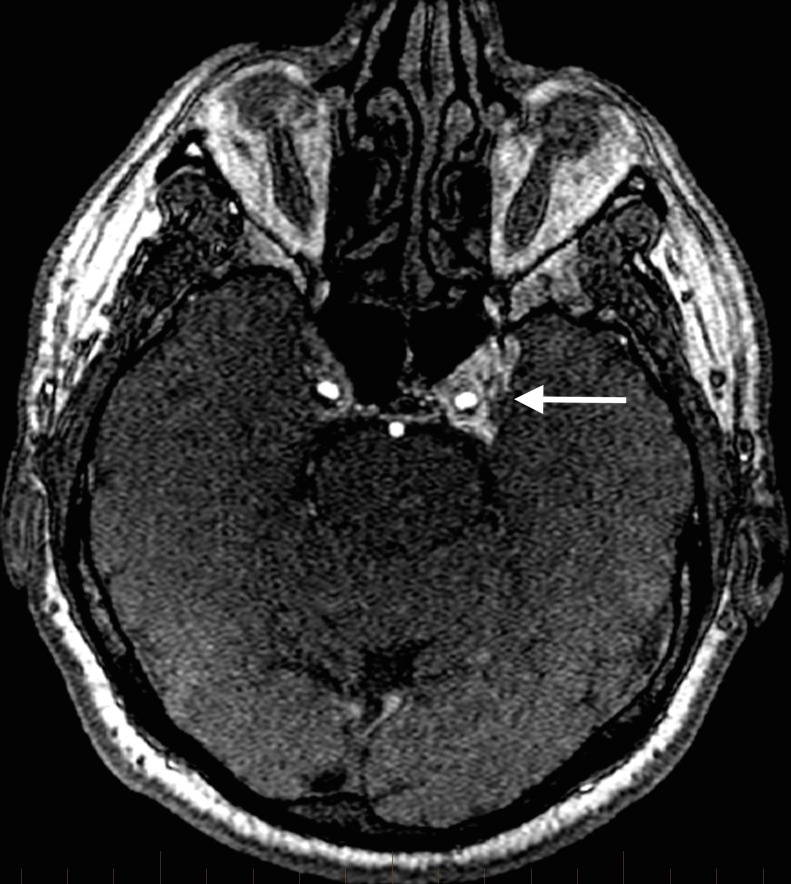

generated 50 captions
['fluorescein angiography of the left eye showing a large filling defect in the left eye', 'chest x-ray showing a large mass in the right lung .', 'chest x-ray showing a large mass in the right lung .', 'mri of the brain with contrast showing a large mass in the left frontal lobe .', '<unk> <unk> : <unk> <unk> .', 'coronary angiogram showing the left anterior descending artery ( lad ) and left circumflex ( <unk> ) .', 'x-ray of the pelvis showing a large osteolytic lesion involving the right side of the pelvis .', 'chest x-ray showing a large mass in the right upper lung field .', 'chest x-ray showing a large left pleural effusion .', 'transthoracic echocardiography showing a large pericardial effusion with a large thrombus in the right atrium .', 'postoperative radiograph .', 'fluoroscopic image of the <unk> ureterorenoscopy . the arrow indicates the tip of the catheter tip in the left atrium .', 'transthoracic echocardiography showing a large pericardial effusio

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing Ber

"{'biobert': {'Cosine Similarity': 0.913141, 'Euclidean Distance': 5.377322196960449, 'Manhattan Distance': 118.97858, 'BLEU Score': 0.13043478260869565, 'Jaccard Similarity': 0.25925925925925924}, 'word2vec': {'Cosine Similarity': 0.76900923, 'Euclidean Distance': 0.7838087677955627, 'Manhattan Distance': 10.70879, 'BLEU Score': 0.13043478260869565, 'Jaccard Similarity': 0.25925925925925924}, 'fasttext': {'Cosine Similarity': 0.84147793, 'Euclidean Distance': 1.17864191532135, 'Manhattan Distance': 16.030952, 'BLEU Score': 0.13043478260869565, 'Jaccard Similarity': 0.25925925925925924}, 'countvectorizer': {'Cosine Similarity': 0.4662524041201569, 'Euclidean Distance': 4.795831523312719, 'Manhattan Distance': 21, 'BLEU Score': 0.13043478260869565, 'Jaccard Similarity': 0.25925925925925924}}"


In [8]:
# get predictions from single encoder model
import json
import os
from PIL import Image as PILImage
# get predictions from single encoder model
encoder_path = 'models/EX1/encoder-best.ckpt'
decoder_path = 'models/EX1/decoder-best.ckpt'
vocab_path = 'vocab_60000.pkl'
embed_size = 256
hidden_size = 512
num_layers = 1
data_json = 'selected_dataset-60000/selected_dataset_60000_info.json'

# get image paths 
generated_captions = []
image_paths = []
GTs = []  # ground truth captions
data_ = json.load(open(data_json))
cnt = 0
for k, v in data_.items():
    for item in v:
        if k == 'test':
            # convert paths for linux
            if not os.name == 'nt':
                new_path = list(item.values())[0]['image_path'].replace('\\', '/')
            else:
                new_path = list(item.values())[0]['image_path']
            image_paths.append(new_path)
            GTs.append(list(item.values())[0]['caption'])
            out = main(new_path, encoder_path, decoder_path, vocab_path, embed_size, hidden_size, num_layers)
            # remove tags
            cleaned_caption = out.replace('<start>', '').replace('<end>', '').strip()
            # show couple of samples 
            if cnt < 4:
                print(cleaned_caption)
                image = PILImage.open(new_path)
                image.show()
            cnt = cnt + 1 
                
            generated_captions.append(cleaned_caption)
print(f'generated {len(generated_captions)} captions')
print(generated_captions)

# use first image 
Generated_caption = generated_captions[0]
GT_caption = GTs[0]
print('Generated_caption', Generated_caption)
print('GT_caption', GT_caption)

results = sent2sent_similarity(Generated_caption, GT_caption)
print(json.dumps(str(results), indent=4))

{
    "GT caption": " Fundus fluorescein angiogram showed delayed filling of retinal arterioles, delayed arteriovenous transit time, with normal choroidal perfusion in the left eye.",
    "generated_caption": "fluorescein angiography of the left eye showing a large filling defect in the left eye",
    "similarity_score": 0.294489909390937,
    "retreived caption": " Fluorescein angiography of the left eye showing early hyperflourescence with central masking inferonasal to the optic disc."
}


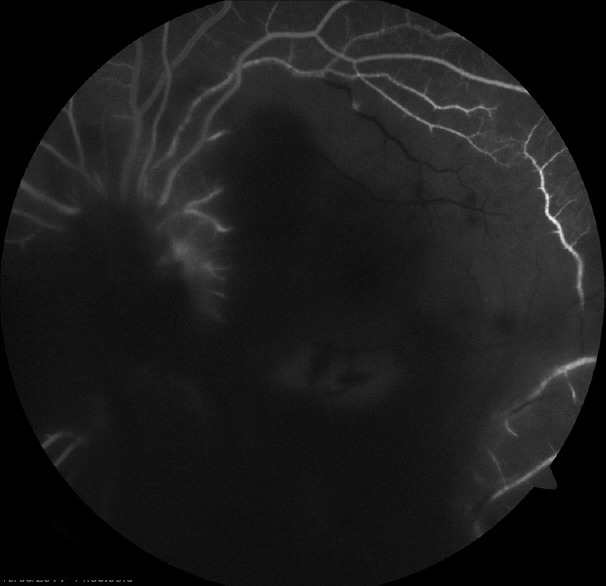

{
    "GT caption": " Improvement of volume of pneumothorax on low pressure, high volume suction.",
    "generated_caption": "chest x-ray showing a large mass in the right lung .",
    "similarity_score": 0.14378418466065584,
    "retreived caption": " Chest radiography showing bilateral lower lobe consolidation with small cavities within focal infiltrates in the right lung"
}


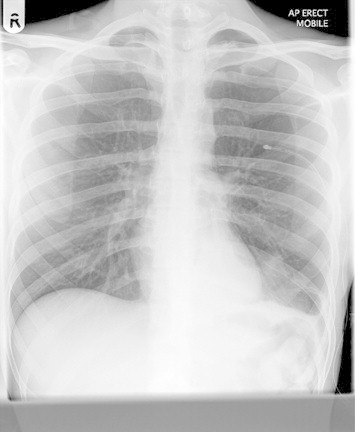

{
    "GT caption": " Chest X-ray (posteroanterior view) shows leftward shifting of the trachea and decreased rib distances in the left side. Compensatory hyperinflation in contralateral hemithorax was also noted.",
    "generated_caption": "chest x-ray showing a large mass in the right lung .",
    "similarity_score": 0.14378418466065584,
    "retreived caption": " Chest radiography showing bilateral lower lobe consolidation with small cavities within focal infiltrates in the right lung"
}


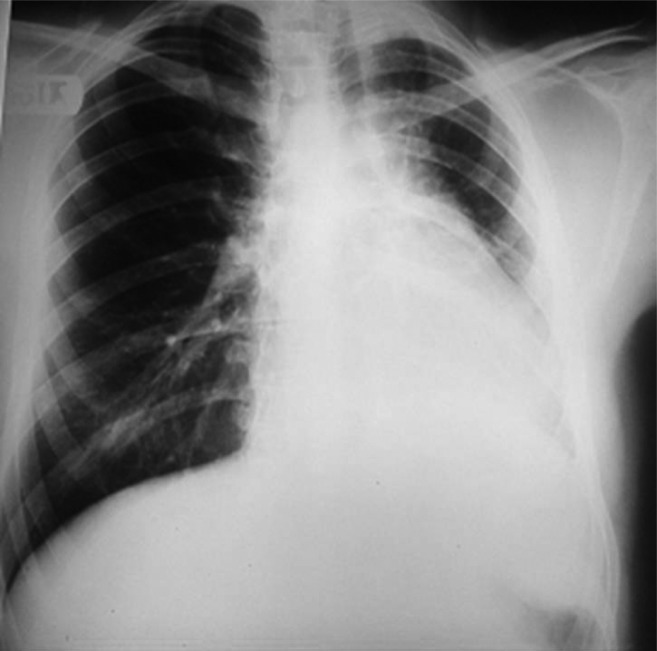

In [9]:
# Question 07: Retreival method: get the most similar caption for generated caption from training set
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
def get_best_match_from_target_list(caption, json_data):
    """
    :param caption: input caption/ generated caption (Y)
    :param json_data: data file to get the training list
    :return: best matching caption for Y <-- (Z)
    """
    data = json.load(open(json_data))
    target_captions = []
    for k, v in data.items():
        if k == 'train':
            for item in v:
                target_captions.append(list(item.values())[0]['caption'])

    best_sim = 0
    best_caption = None
    for train_cap in target_captions:
        # cosine_sim = calculate_countvector_similarity(train_cap, caption)
        # if best_sim < cosine_sim['Cosine Similarity']:
        #     best_sim = cosine_sim['Cosine Similarity']
        #     best_caption = train_cap
        reference = train_cap.split()
        hypothesis = caption.split()
        # Calculate BLEU score for the pair
        score = sentence_bleu([reference], hypothesis, smoothing_function=SmoothingFunction().method1)
        if best_sim < score:
            best_sim = score
            best_caption = train_cap
    return best_sim, best_caption

#Q7
# get the most similar caption for generated caption from training set, for all the test images 
json_data = 'selected_dataset/selected_dataset_info.json'
best_similarities_Z = []
best_matching_captions_Z = []

for i, Generated_caption in enumerate(generated_captions):
    best_similarity, best_matching_caption = get_best_match_from_target_list(Generated_caption, json_data)
    best_similarities_Z.append(best_similarity)
    best_matching_captions_Z.append(best_matching_caption)
    res = {'GT caption':GTs[i], 'generated_caption': Generated_caption, 'similarity_score': best_similarity, 'retreived caption': best_matching_caption}
    # print Coupe of matches from retreival 
    if i < 3:
        print(json.dumps(res, indent=4))
        image = PILImage.open(image_paths[i])
        image.show()


{
    "GT caption": " Fundus fluorescein angiogram showed delayed filling of retinal arterioles, delayed arteriovenous transit time, with normal choroidal perfusion in the left eye.",
    "generated_caption": "fluorescein angiography of the left eye showing a large filling defect in the left eye",
    "retreived_caption": " Fluorescein angiography of the left eye showing early hyperflourescence with central masking inferonasal to the optic disc.",
    "final_caption": " Fluorescein angiography of the left eye showing early hyperflourescence with central masking inferonasal to the optic disc."
}


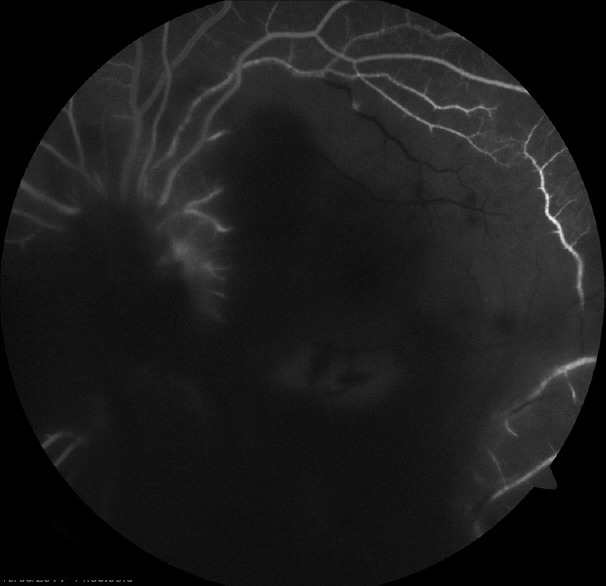

{
    "GT caption": " Improvement of volume of pneumothorax on low pressure, high volume suction.",
    "generated_caption": "chest x-ray showing a large mass in the right lung .",
    "retreived_caption": " Chest radiography showing bilateral lower lobe consolidation with small cavities within focal infiltrates in the right lung",
    "final_caption": " Chest radiography showing bilateral lower lobe consolidation with small cavities within focal infiltrates in the right lung"
}


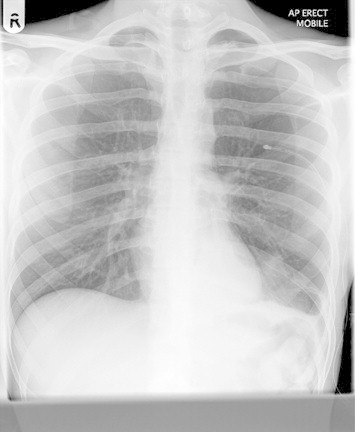

{
    "GT caption": " Chest X-ray (posteroanterior view) shows leftward shifting of the trachea and decreased rib distances in the left side. Compensatory hyperinflation in contralateral hemithorax was also noted.",
    "generated_caption": "chest x-ray showing a large mass in the right lung .",
    "retreived_caption": " Chest radiography showing bilateral lower lobe consolidation with small cavities within focal infiltrates in the right lung",
    "final_caption": " Chest radiography showing bilateral lower lobe consolidation with small cavities within focal infiltrates in the right lung"
}


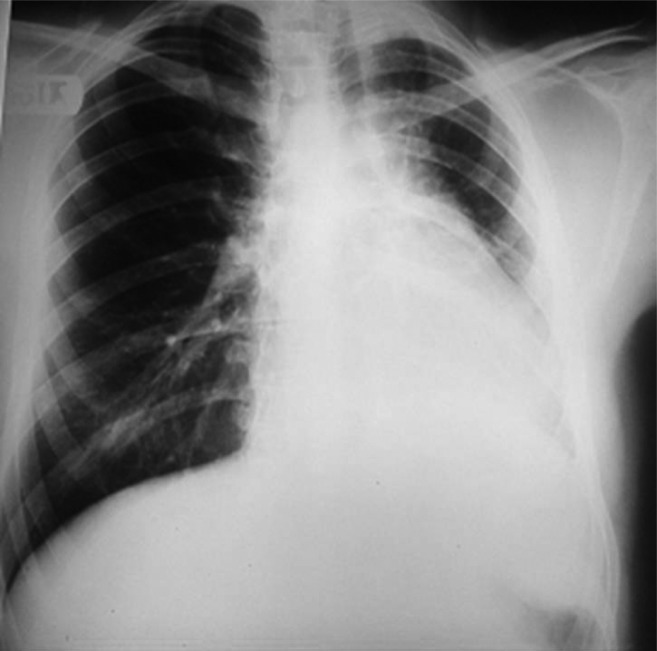

[' Fluorescein angiography of the left eye showing early hyperflourescence with central masking inferonasal to the optic disc.', ' Chest radiography showing bilateral lower lobe consolidation with small cavities within focal infiltrates in the right lung', ' Chest radiography showing bilateral lower lobe consolidation with small cavities within focal infiltrates in the right lung', ' The contrast-enhanced CT scan showing a hyperdense, well-demarcated lesion with peripheral calcification in the left frontal lobe', ' : Radiograph taken two months postoperatively showing healing callus formation', ' Following an intracoronary injection of nitroglycerin in case 1, the left anterior descending and left circumflex artery spasms were partially relieved.', ' A 3D reformat of the contrast-enhanced computed tomography of the pelvis showing a ruptured aneurysm with an associated pseudoaneurysm.', ' Abdominal CT scan showing a radio-opaque faecolith in the right upper quadrant (arrowed)', ' Echoca

In [10]:
# Question 8: compare GT (X) with (Y) and (Z) and get the best caption as (Y) or (Z) and assigned it to test image
def get_best_caption(X_Y_sim_score, X_Z_sim_score, Y, Z):
    """
    :param Z: retrival caption from training set for generated caption
    :param Y: generated caption
    :param X_Y_sim_score: similarity score between GT (X) and generated caption (Y)
    :param X_Z_sim_score: similarity score between GT (X) and retrival caption from training set (Z)
    :return: (Y) or (Z)
    """
    if X_Y_sim_score > X_Z_sim_score:
        ret = Y
    else:
        ret = Z
    return ret


# Q8
final_captions = []
for i, (GT_caption, Generated_caption) in enumerate(zip(GTs, generated_captions)):
    # cosine_sim = calculate_countvector_similarity(GT_caption, Generated_caption)
    # Calculate BLEU score for the pair
    score = sentence_bleu([GT_caption.split()], Generated_caption.split(), smoothing_function=SmoothingFunction().method1)
    final_caption = get_best_caption(score, best_similarities_Z[i], Generated_caption, best_matching_captions_Z[i])
    # print couple of samples
    res = {'GT caption':GT_caption, 'generated_caption': Generated_caption, 'retreived_caption': best_matching_captions_Z[i], "final_caption": final_caption }
    if i < 3:
        print(json.dumps(res, indent=4))
        image = PILImage.open(image_paths[i])
        image.show()
    final_captions.append(final_caption)
print(final_captions)

In [11]:
# Question9: Evaluation of the predictions
from rouge import Rouge 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from bleurt import score as bleurt_score
from bert_score import score

rouge = Rouge()
cider_scorer = Cider()

def get_average_BERTScore(candidates, references):
    P, R, F1 = score(candidates, references, lang='en', verbose=True)
    return {
        "precision": P.mean().item(),
        "recall": R.mean().item(),
        "f1": F1.mean().item()
    }

def get_average_BLEURT(candidates, references, bleurt_checkpoint='BLEURT-20-D12/'):
    bleurt_scorer = bleurt_score.BleurtScorer(bleurt_checkpoint)
    scores = bleurt_scorer.score(references=references, candidates=candidates)
    average_bleurt = sum(scores) / len(scores)
    return average_bleurt

def get_average_spice(generated_captions, ground_truth_captions):
    # Create dictionaries for the scorer where the keys are image ids
    gts = {}
    res = {}
    for idx, (gen_caption, gt_caption) in enumerate(zip(generated_captions, ground_truth_captions)):
        gts[idx] = [gt_caption]  # Ground truth captions
        res[idx] = [gen_caption]  # Generated captions

    # Create SPICE scorer
    spice_scorer = Spice()
    
    # Compute the score
    score, scores = spice_scorer.compute_score(gts, res)
    
    # The score is the average SPICE score
    return score

def get_average_cider(predicted_captions, ground_truth_captions):
    """
    Calculate the average CIDEr score for lists of predicted captions and their corresponding ground truth captions.
    """
    # dictionary of ground truth and predicted captions with unique image IDs
    gts = {}
    res = {}

    for idx, (predicted, ground_truth) in enumerate(zip(predicted_captions, ground_truth_captions)):
        gts[idx] = ground_truth
        res[idx] = [predicted]

    # Compute CIDEr score
    score, _ = cider_scorer.compute_score(gts, res)
    return score


def get_average_meteor(predicted_captions, ground_truth_captions):
    """
    Calculate the average METEOR score for lists of predicted captions and their corresponding ground truth captions.
    """
    meteor_score_sum = 0.0
    # Loop through each predicted and true caption pair and calculate METEOR score
    for predicted, ground_truth in zip(predicted_captions, ground_truth_captions):
        # Calculate METEOR score for the pair
        score = single_meteor_score(ground_truth.split(), predicted.split())
        meteor_score_sum += score
    # Calculate the average METEOR score
    avg_meteor_score = meteor_score_sum / len(predicted_captions)
    return avg_meteor_score

def get_average_bleu(predicted_captions, ground_truth_captions):
    """
    Calculate the average BLEU score for lists of predicted captions and their corresponding ground truth captions.
    """
    bleu_score_sum = 0.0
    # Define the smoothing function
    smoothing_function = SmoothingFunction().method1
    # Loop through each predicted and true caption pair and calculate BLEU score
    for predicted, ground_truth in zip(predicted_captions, ground_truth_captions):
        # Tokenize the ground truth and predicted captions
        reference = ground_truth.split()
        hypothesis = predicted.split()
        # Calculate BLEU score for the pair
        score = sentence_bleu([reference], hypothesis, smoothing_function=smoothing_function)
        bleu_score_sum += score
    # Calculate the average BLEU score
    avg_bleu_score = bleu_score_sum / len(predicted_captions)
    return avg_bleu_score

def get_average_rouge(predicted_captions, ground_truth_captions):
    # Calculate scores for each pair
    scores = [rouge.get_scores(pred, true) for pred, true in zip(predicted_captions, ground_truth_captions)]

    # Sum up all ROUGE-1, ROUGE-2, and ROUGE-L F-scores
    total_scores = {
        'rouge-1': {'f': 0},
        'rouge-2': {'f': 0},
        'rouge-l': {'f': 0}
    }

    for score in scores:
        total_scores['rouge-1']['f'] += score[0]['rouge-1']['f']
        total_scores['rouge-2']['f'] += score[0]['rouge-2']['f']
        total_scores['rouge-l']['f'] += score[0]['rouge-l']['f']

    # Calculate average score
    avg_scores = {
        'rouge-1': {'f': total_scores['rouge-1']['f'] / len(predicted_captions)},
        'rouge-2': {'f': total_scores['rouge-2']['f'] / len(predicted_captions)},
        'rouge-l': {'f': total_scores['rouge-l']['f'] / len(predicted_captions)}
    }

    return avg_scores

# Q9
eval_scores= {}
avg_rouge = get_average_rouge(generated_captions, GTs)
eval_scores['ROUGE'] = avg_rouge
avg_bleu = get_average_bleu(generated_captions, GTs)
eval_scores['BLEU'] = avg_bleu
avg_meteor = get_average_meteor(generated_captions, GTs)
eval_scores['METEOR'] = avg_meteor
# avg_CIDEr = get_average_cider(generated_captions, GTs)
# eval_scores['CIDEr'] = avg_CIDEr
avg_spice = get_average_spice(generated_captions, GTs)
eval_scores['SPICE'] = avg_spice
avg_bert = get_average_BERTScore(generated_captions, GTs)
eval_scores['BERT'] = avg_bert

avg_BLEURT = get_average_BLEURT(generated_captions, GTs)
eval_scores['BLEURT'] = avg_BLEURT



print(f"Evaluation scores: ")
print(json.dumps(eval_scores, indent=4))

2023-11-04 22:03:59.740763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 22:03:59.979827: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 22:04:01.680100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib

SPICE evaluation took: 1.261 s


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.75 seconds, 66.24 sentences/sec
INFO:tensorflow:Reading checkpoint BLEURT-20-D12/.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint BLEURT-20-D12
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:BLEURT-20-D12
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:... vocab_file:None
INFO:tensorflow:... do_lower_case:None
INFO:tensorflow:... sp_model:sent_piece
INFO:tensorflow:... dynamic_seq_length:True
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Creating SentencePiece tokenizer.
INFO:tensorflow:Will load model: BLEURT-20-D12/sent_piece.model.
INFO:tensorflow:SentencePiece tokenizer created.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.


2023-11-04 22:04:25.665559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-04 22:04:25.671454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-04 22:04:25.672649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-04 22:04:25.674147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

INFO:tensorflow:BLEURT initialized.
Evaluation scores: 
{
    "ROUGE": {
        "rouge-1": {
            "f": 0.1811082212778001
        },
        "rouge-2": {
            "f": 0.04894173015920889
        },
        "rouge-l": {
            "f": 0.161912190719134
        }
    },
    "BLEU": 0.019048919968535465,
    "METEOR": 0.13103812489907832,
    "SPICE": 0.06369296677662309,
    "BERT": {
        "precision": 0.8624765276908875,
        "recall": 0.8416658043861389,
        "f1": 0.8514954447746277
    },
    "BLEURT": 0.24378390043973922
}
